# Improving Computer Vision Accuracy using Convolutions

In [2]:
# Naive implementation without Convolutions

import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(units = 10, activation=tf.nn.softmax)])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(training_images, training_labels, epochs = 5)
test_loss = model.evaluate(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4945 - accuracy: 0.8259
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3733 - accuracy: 0.8672
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3337 - accuracy: 0.8792
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3124 - accuracy: 0.8845
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3490 - accuracy: 0.8755


Accuracy is probably about 89% on training and 87% on validation...not bad...But how to make that even better? One way is to use something called Convolutions.

In short, you take an array (usually 3x3 or 5x5) and pass it over the image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. 

This is perfect for computer vision, because often it's features that can get highlighted like this that distinguish one item for another, and the amount of information needed is then much less...because you'll just train on the highlighted features.

That's the concept of Convolutional Neural Networks. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focussed, and possibly more accurate.

In [5]:
# Implementation with convolutions

import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images.reshape(60000, 28, 28, 1)
training_images = training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images = test_images / 255.0
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units = 128, activation = 'relu'),
                                    tf.keras.layers.Dense(units = 10, activation='softmax')])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs = 5)
test_loss = model.evaluate(test_images, test_labels)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

t's likely gone up to about 93% on the training data and 91% on the validation data. 

That's significant, and a step in the right direction!

there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape. 


Next is to define your model. Now instead of the input layer at the top, you're going to add a Convolution. The parameters are:

1. The number of convolutions you want to generate. Purely arbitrary, but good to start with something in the order of 32
2. The size of the Convolution, in this case a 3x3 grid
3. The activation function to use -- in this case we'll use relu, which you might recall is the equivalent of returning x when x>0, else returning 0
4. In the first layer, the shape of the input data.

You'll follow the Convolution with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1. It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.

You can call model.summary() to see the size and shape of the network, and you'll notice that after every MaxPooling layer, the image size is reduced in this way. 


# Visualizings the Convolutions and Pooling

In [6]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


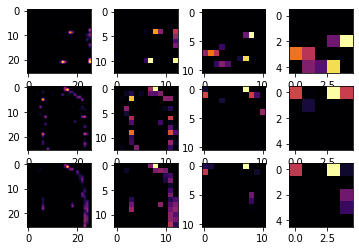

In [14]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)